In [15]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
import forecast
import emcee
from lnlikelihood import lnLikelihood
import pyccl as ccl
import edit, sys
import h5py, glob
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def load_pickle(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [17]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC')
import analysis

In [18]:
d = '/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/SSC_contribution/SSC/'

In [55]:
gauss_Omapprox = []
sn_Omapprox = []
ssc_contOmapprox = []
file_binned_approx = ['Om_SSC_contribution_binned_approx_5zx5m_14.40_15.60.pkl', 
               'Om_SSC_contribution_binned_approx_10zx10m_14.40_15.60.pkl',
              'Om_SSC_contribution_binned_approx_70zx70m_14.40_15.60.pkl',
              'Om_SSC_contribution_binned_approx_100zx100m_14.40_15.60.pkl']
for f in file_binned_approx:
    Om, y = np.load(d+f, allow_pickle=True)
    gauss_Omapprox.append([y[i][0] for i in range(len(Om))])
    sn_Omapprox.append([y[i][1] for i in range(len(Om))])
    ssc_contOmapprox.append([y[i][2] for i in range(len(Om))])

In [66]:
gauss_Omfull = []
sn_Omfull = []
ssc_contOmfull = []
file_binned_full = ['Om_SSC_contribution_binned_full_5zx5m_14.20_15.60.pkl', 
               'Om_SSC_contribution_binned_full_10zx10m_14.20_15.60.pkl',
              'Om_SSC_contribution_binned_full_70zx70m_14.20_15.60.pkl',
              'Om_SSC_contribution_binned_full_100zx100m_14.20_15.60.pkl'
                   ]
for f in file_binned_full:
    Om, y = np.load(d+f, allow_pickle=True)
    gauss_Omfull.append([y[i][0] for i in range(len(Om))])
    sn_Omfull.append([y[i][1] for i in range(len(Om))])
    ssc_contOmfull.append([y[i][2] for i in range(len(Om))])

FileNotFoundError: [Errno 2] No such file or directory: '/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/SSC_contribution/SSC/Om_SSC_contribution_binned_full_100zx100m_14.20_15.60.pkl'

0.04539745254572276
0.045468820377106936
1.0007857247561085
0.04541128697518185
0.0454725391086397
1.0006741880352503
0.04348899655416775
0.04342107312450104
0.9992187682242711
0.04348150790660982
0.04342298422971816
0.9993268013763497


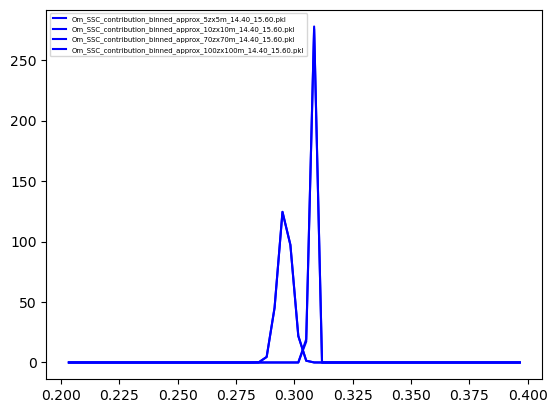

In [65]:
mask = (Om > 0.2)*(Om < 0.4)
#plt.ylim(-2, 10)
for i, f in enumerate(file_binned_full):
        #if i != 3: continue
        lnL_gauss_full = gauss_Omfull[i]
        lnL_sn_full = sn_Omfull[i]
        P_gauss_full1 = np.exp(lnL_gauss_full - np.max(lnL_gauss_full))
        P_gauss_full = P_gauss_full1/np.trapz(P_gauss_full1, Om)
        #
        meanOm = np.trapz(Om**2*P_gauss_full, Om)
        var_gauss_full = np.trapz((Om - meanOm)**2*P_gauss_full, Om)
        print(var_gauss_full)
        P_sn_full1 = np.exp(lnL_sn_full - np.max(lnL_sn_full))
        P_sn_full = P_sn_full1/np.trapz(P_sn_full1, Om)
        #
        meanOm = np.trapz(Om**2*P_sn_full, Om)
        var_sn_full = np.trapz((Om - meanOm)**2*P_sn_full, Om)
        print(var_sn_full)
        print((var_sn_full/var_gauss_full)**.5)
        #plt.plot(Om, P_gauss_full)
        #plt.plot(Om[mask], P_gauss_full[mask], '--', label = file_binned_approx[i])
        plt.plot(Om[mask], P_sn_full[mask], '-b', label = file_binned_approx[i])
        #plt.plot(Om[mask], P_gauss_full[mask], '-g', label = file_binned_approx[i])
        #lnL_gauss_approx = gauss_Omapprox[i]
        #lnL_sn_approx = sn_Omapprox[i]
       # P_gauss_approx1 = np.exp(lnL_gauss_approx - np.max(lnL_gauss_approx))
        #P_gauss_approx = P_gauss_approx1/np.trapz(P_gauss_approx1, Om)
       # P_sn_approx1 = np.exp(lnL_sn_approx - np.max(lnL_sn_approx))
       # P_sn_approx = P_sn_approx1/np.trapz(P_sn_approx1, Om)
        #plt.plot(Om[mask], P_sn_approx[mask]/P_gauss_approx[mask], '-', label = file_binned_approx[i])
    #plt.plot(Om[mask], P_sn_approx[mask], '--', label = file_binned_approx[i])
        #plt.plot(Om[mask], np.log(P_gauss_approx[mask]/P_sn_approx[mask]), '--', label = file_binned_approx[i])
        #y_post = np.exp(y_ - np.max(y_))
        #y_post1 = np.exp(ysn[i] - np.max(ysn[i]))
        #mask = (x[i] > 0.295)*(x[i] < 0.33)
        #@fssc = np.log((y_post[mask]/y_post1[mask]))
        #fssc = fssc-np.min(fssc)
        #plt.plot(x[i][mask], fssc, ls='-',lw=1)
   
        plt.legend(fontsize=5)

In [22]:
for i, y_ in enumerate(yfull):
    print(i)
   
    plt.plot(x[i][mask], f, ls='-',lw=1)
   


NameError: name 'yfull' is not defined